# KPCA LAB.4 Solutions

## Exercise 1

First of all let's import the useful modules.

In [1]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt # plotting
import pandas as pd # csv manipulation
from scipy.spatial.distance import cdist # for pairwise distances kernels
from scipy.sparse import linalg as LA # for linear algebra
from scipy.sparse import csr_matrix # for sparse matrices
from sklearn.decomposition import PCA as SklearnPCA # for comparison
from sklearn.decomposition import KernelPCA as SklearnKernelPCA # for comparison


The PCA is implemented as a class, following the same schema as `scikit-learn`, and is copied from Lab2 implementation.

In [2]:
class PCA(object):
    
    def __init__(self):
        
        self.eigenvalues = None
        self.transformation_matrix = None
        self._mean = None
    
    def fit(self, x):
                
        # centered data
        self._mean = np.mean(x, axis=0)
        x_c = x - self._mean
        
        # compute covariance matrix (X^t X)/n_samples
        conv_matrix = np.dot(x_c.T, x_c) / x.shape[0]
        self.conv = conv_matrix
        
        # decompose the matrix
        eigvalues, eigvects = np.linalg.eigh(conv_matrix)
        
        # sort in ascending order
        idx = eigvalues.argsort()[::-1]   
        self.eigenvalues = eigvalues[idx]
        self.transformation_matrix = eigvects[:,idx]

        
    def transform(self, x, numb_components = None, eigen = False):
        
        # centered data
        x_c = x - self._mean
        
        # check consistency number of components
        numb_components = self._check_numb_components(x_c, numb_components)
        
        # choose the eigenvect/eigenval according to the number of components
        eigvalues = self.eigenvalues[:numb_components]
        transform_matrix = self.transformation_matrix[:, :numb_components]
        
        # project data
        projection = np.dot(x, transform_matrix)
        
        if eigen:
            return projection, eigvalues
        
        return projection
    
    def inverse_transform(self, y):
        # number of samples and features
        n_samples, n_features = y.shape
        # define tranformation matrix
        transform_matrix = self.transformation_matrix[:, :n_features]
        # return transformation + the mean vector
        return np.dot(y, transform_matrix.T) + self._mean
    
    def _check_numb_components(self, x, numb_components):
        """
        Expect input shape to be numb_sample X dimension_sample. 
        """
        # number of samples and features
        n_samples, n_features = x.shape
        
        # check consistency
        if numb_components is None:
            numb_components = n_features
            
        if numb_components < 1 or numb_components > n_features:
            raise ValueError("numb_components must be greater or equal than one"
                             " and smaller or equal to the number of features")
            
        return numb_components

We now implement kernel KernelPCA as a class as well, following the same schema as `scikit-learn`. We only implement the fit_transform method, which is the only one required for the exercise. Notice that we use sparse matrix algebra operation to speed up computations.

In [18]:
class KernelPCA(object):

    def __init__(self, kernel, gamma=1.0):
        """Kernel PCA implementation.

        :param kernel: pca kernel {'poly', 'rbf'} possible option.
        :type kernel: string
        :param gamma: coefficient for rbf, poly kernel; ignored by others.
        :type gamma: int
        """

        # list of possible kernels
        possible_kernels = ['poly', 'gaussian']

        if kernel not in possible_kernels:
            raise ValueError(
                "expected kernel to be in list of possible kernels.")
        else:
            self._kernel = self._choose_kernel(kernel)

        # gamma coefficient + alpha coefficient
        self._gamma = gamma


    def fit_transform(self, X, numb_components=None, eigen=False):

        (m, _) = X.shape

        self._check_numb_components(X, numb_components)

        # creating kernel matrix
        K = csr_matrix(self._kernel(X))

        # centering matrix
        I = csr_matrix(np.identity(m) - np.ones(shape=(m,m))/m)
        K = I.multiply(K.multiply(I))

        # performing svd
        eigvalues, eigvects= LA.eigsh(K, k=numb_components, which='LM')
        eigvects = eigvects / eigvalues

        # sort in ascending order
        idx = eigvalues.argsort()[::-1]
        eigvalues = eigvalues[idx]
        eigvects = eigvects[:, idx]

        # project data (use shortcut for just projecting)
        projection = np.dot(eigvects, np.sqrt(np.diag(eigvalues)))

        if eigen:
            return projection, eigvalues

        return projection


    def _choose_kernel(self, kernel_type):
        """
        Returning the right kernel.
        """
        def rbf(X, X_train=None):
            if X_train is None:
                X_train = X
            dists = cdist(X, X_train, metric="sqeuclidean")
            K = np.exp(-0.5 * (dists / self._gamma))
            return K

        def poly(X, X_train=None):
            if X_train is None:
                X_train = X
            K = 1. + np.dot(X, X_train.T)
            return np.power(K, self._gamma)

        kernels = {'gaussian': rbf,
                   'poly': poly}

        return kernels[kernel_type]

    def _check_numb_components(self, x, numb_components):
        """
        Expect input shape to be numb_sample X dimension_sample. 
        """
        # number of samples and features
        _, n_features = x.shape

        # check consistency
        if numb_components is None:
            numb_components = n_features

        if numb_components < 1 or numb_components > n_features:
            raise ValueError("numb_components must be greater or equal than one"
                             " and smaller or equal to the number of features")

        return numb_components


Now that we have implemented all classes, let's begin with the exercise

In [12]:
# get the data
X = np.genfromtxt("../Datasets/data_kPCA_2022-2023.txt")
y = np.genfromtxt("../Datasets/labels_kPCA_2022-2023.txt")

### PCA results

Let's first plot on the first two principal components the dataset, and compare it to sklearn implementation.

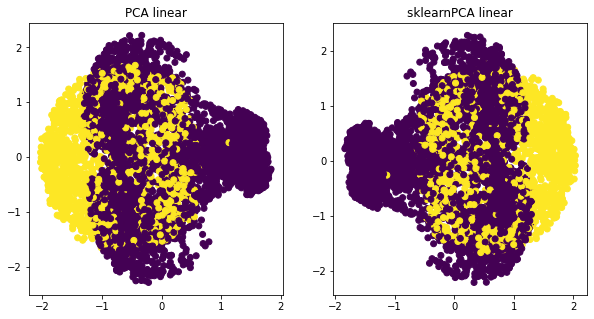

In [13]:
# my pca
pca = PCA()
pca.fit(X)
X_projected = pca.transform(X, numb_components=2)


# sklearn  pca
s_pca = SklearnPCA(n_components=2)
s_pca.fit(X)
s_X_projected = s_pca.transform(X)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(X_projected[:,0], X_projected[:,1], c = y)
ax1.set_title('PCA linear')

ax2.scatter(s_X_projected[:,0], s_X_projected[:,1], c = y)
ax2.set_title('sklearnPCA linear')

plt.show()

which are analougous result, due to the $180^\circ$ invarance.

### Kernel PCA results

Firstly we try gaussian kernel

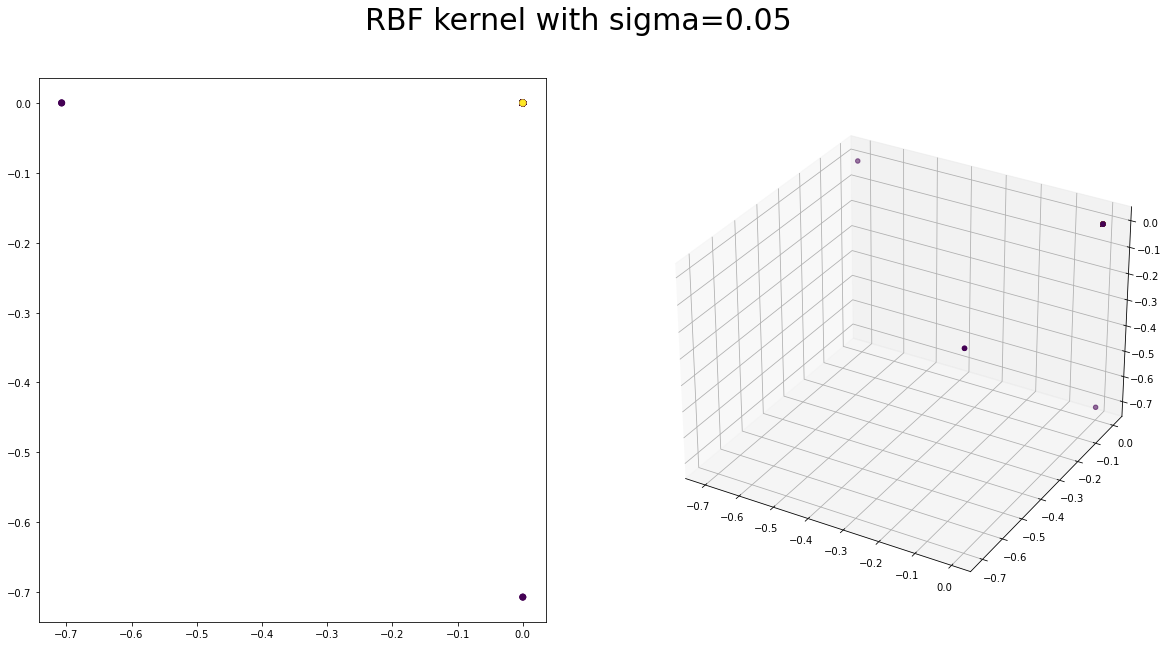

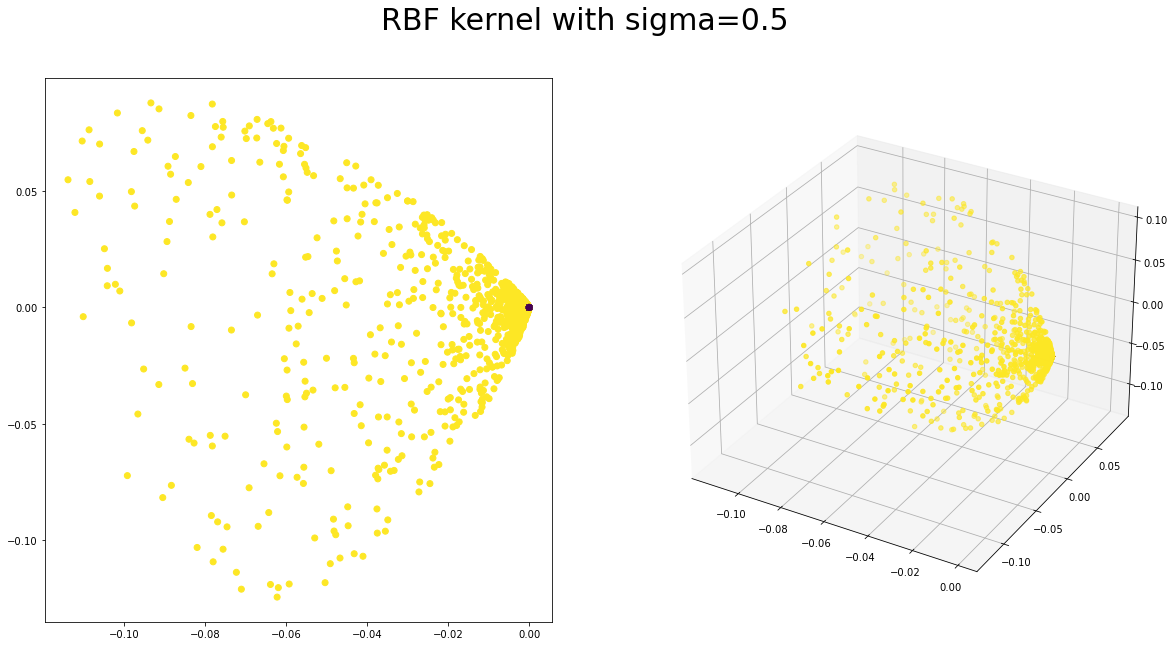

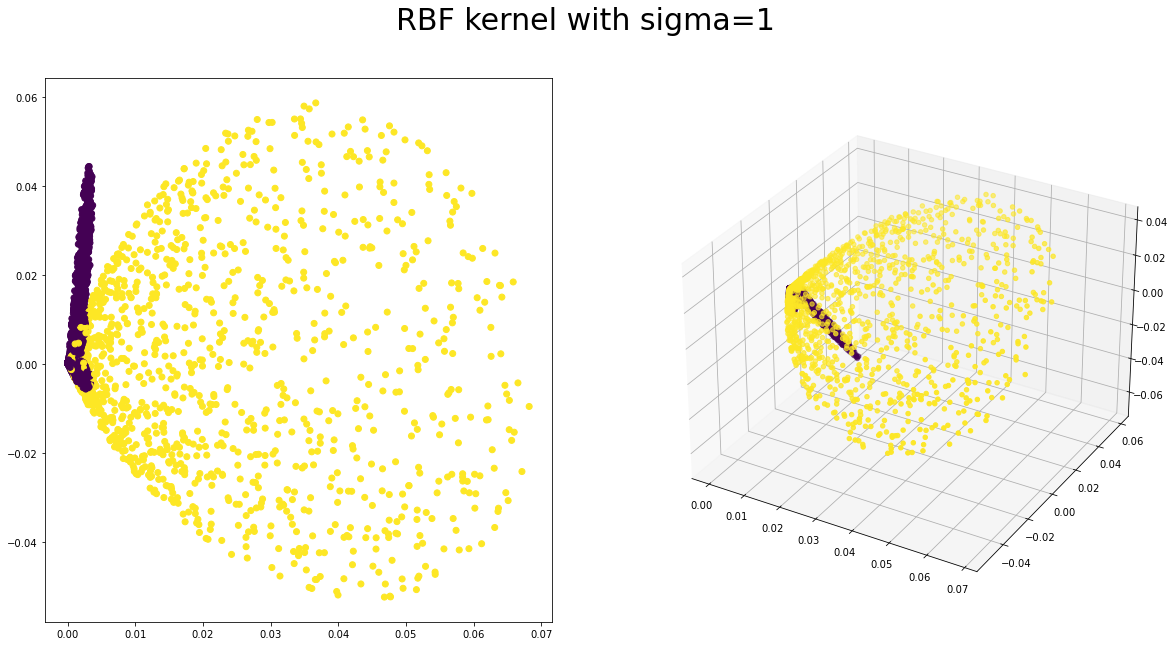

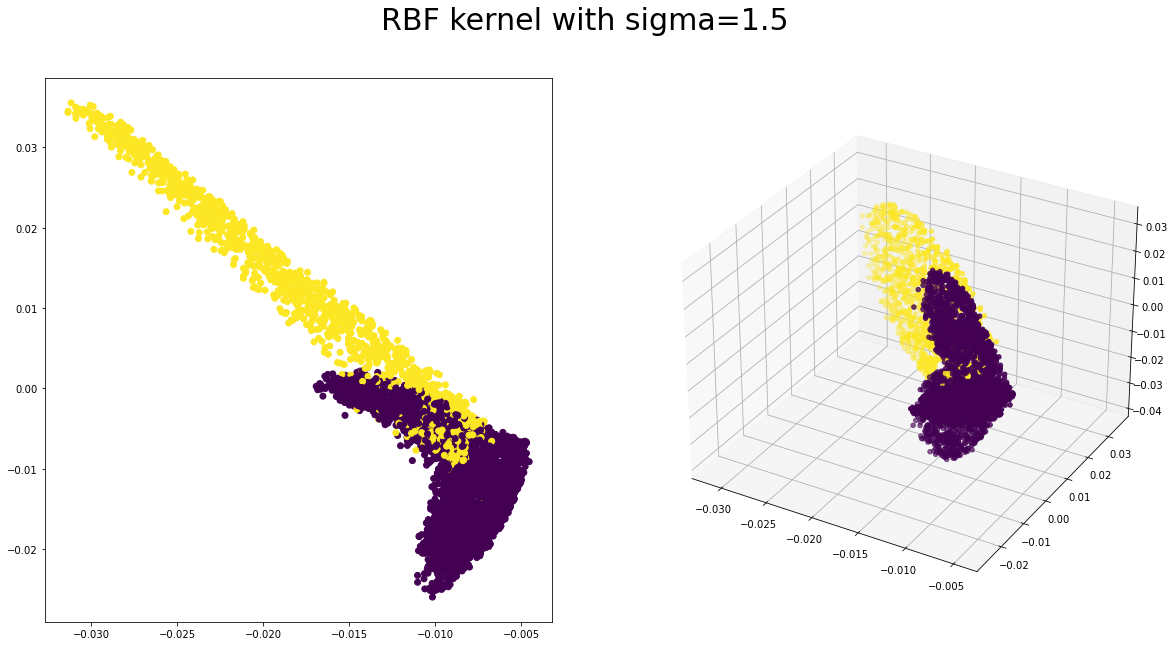

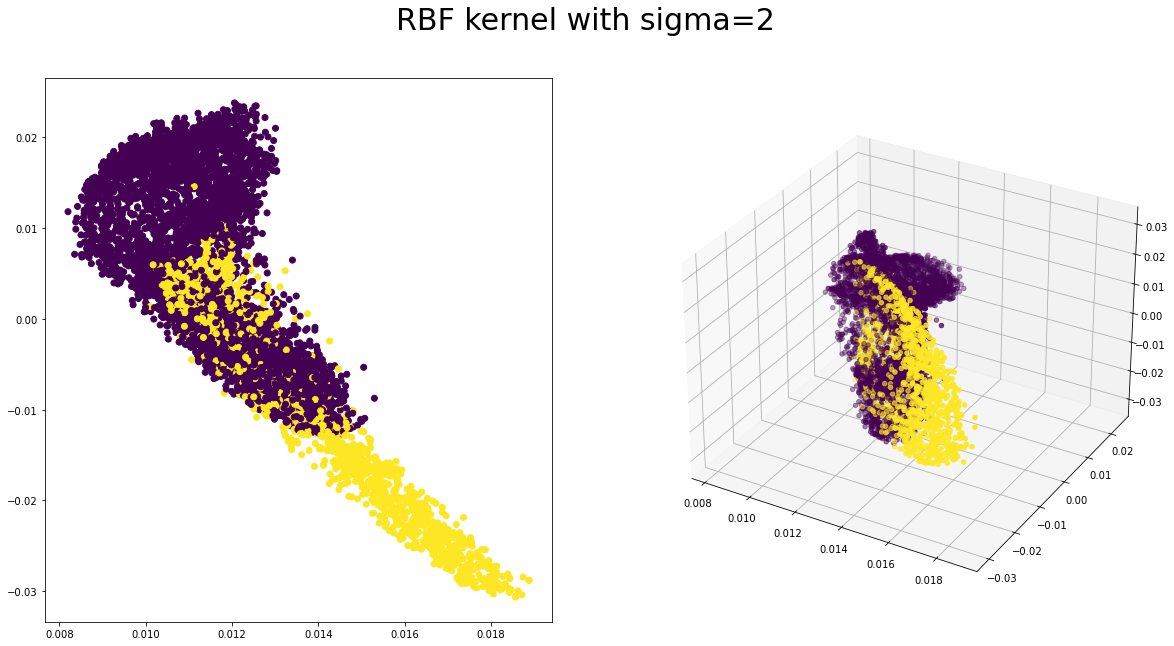

In [14]:
for sigma in [0.05, 0.5, 1, 1.5, 2]:
    kpca = KernelPCA(kernel='gaussian', gamma=sigma**2)
    X_new = kpca.fit_transform(X, numb_components=3)

    fig = plt.figure(figsize=(20, 10))
    fig.suptitle(f"RBF kernel with sigma={sigma}", fontsize=30)
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(X_new[:, 0], X_new[:, 1], c=y)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X_new[:, 0], X_new[:, 1], X_new[:, 2], c=y)
    plt.show()


Now we try with polynomial kernel

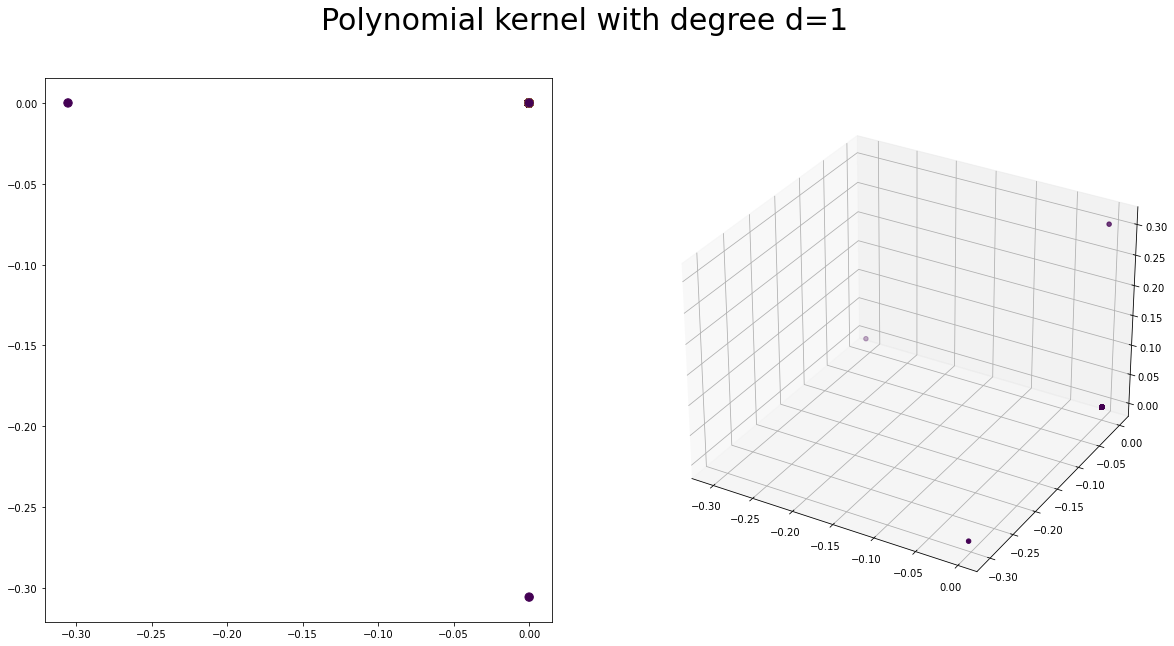

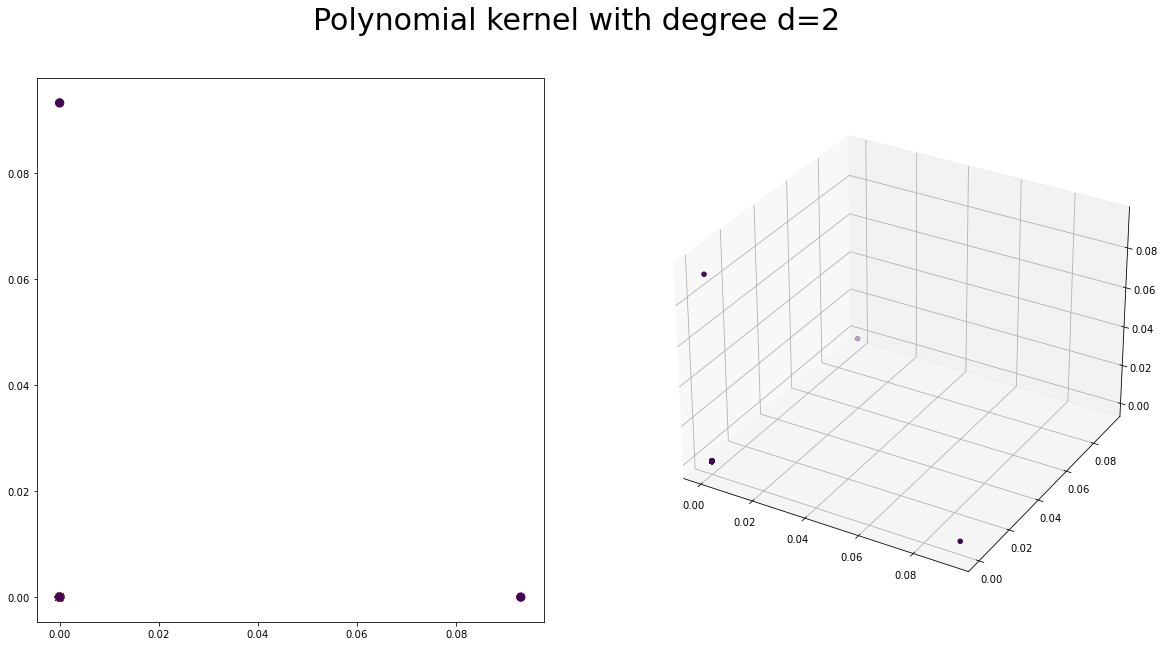

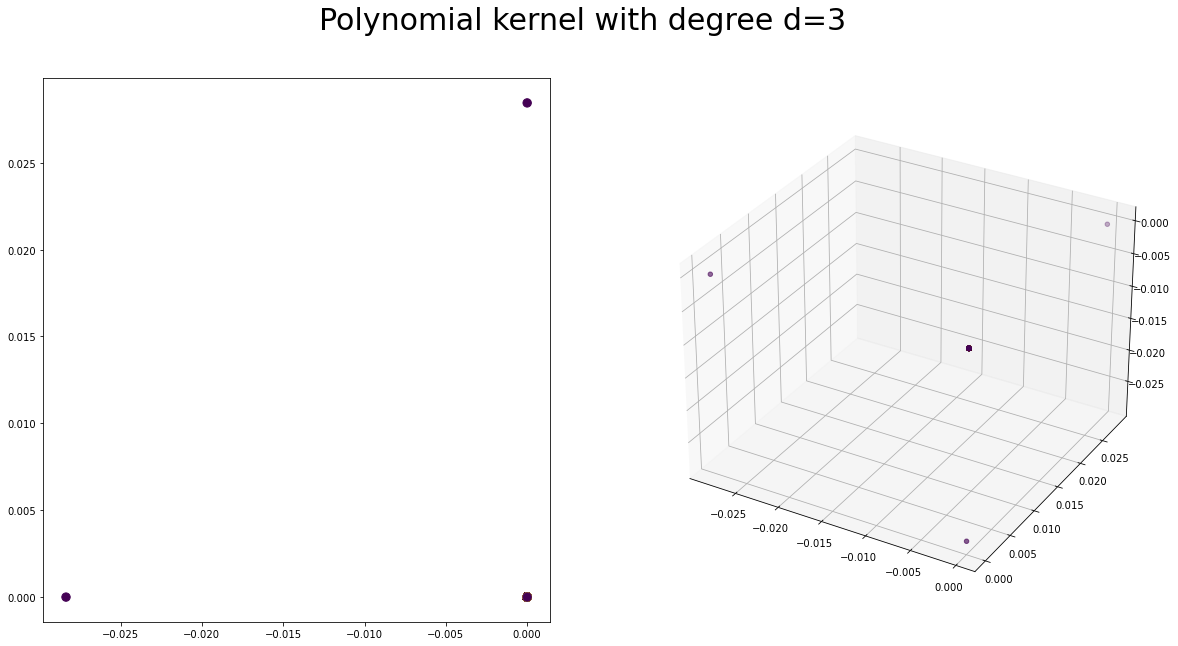

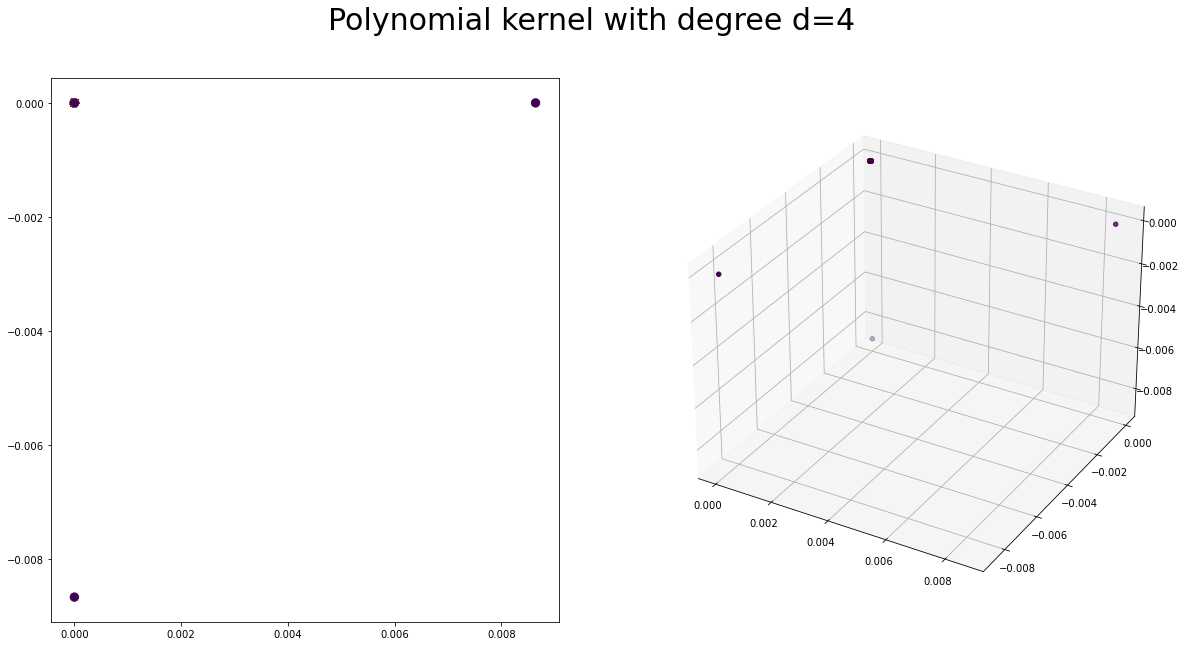

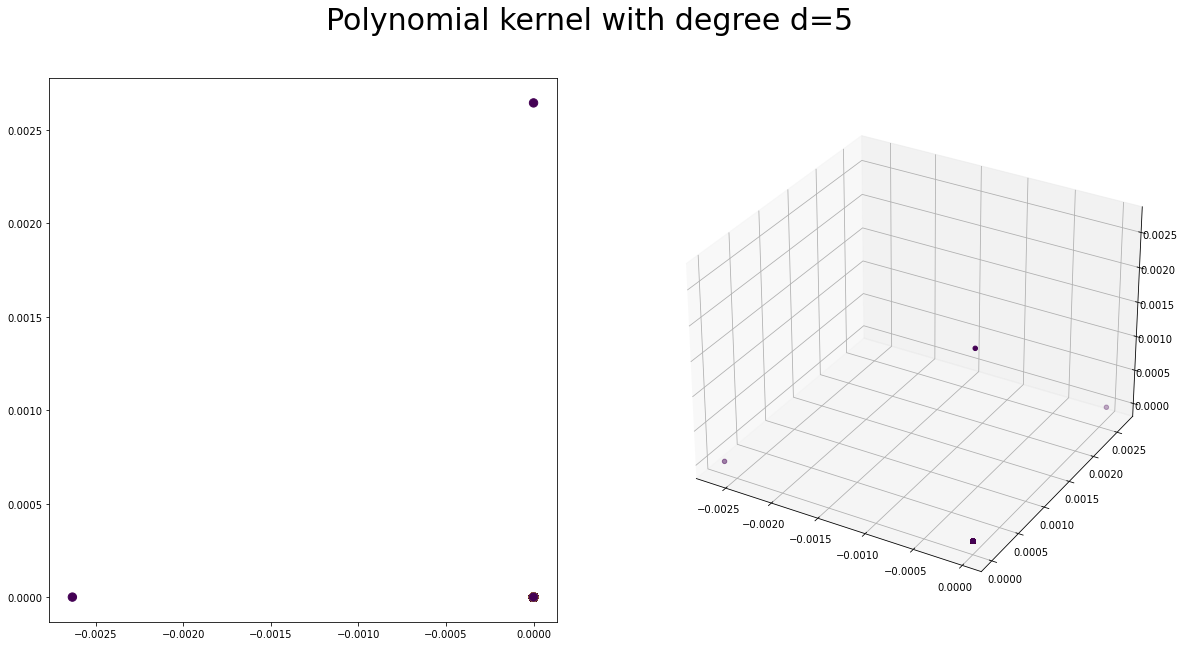

In [20]:
for degree in [1,2,3,4,5]:
    kpca_poly = KernelPCA(kernel='poly', gamma=degree)
    X_new_poly = kpca_poly.fit_transform(X, numb_components=3)
    

    fig = plt.figure(figsize=(20,10))
    fig.suptitle(f"Polynomial kernel with degree d={degree}", fontsize=30)
    ax = fig.add_subplot(1,2,1)
    ax.scatter(X_new_poly[:,0], X_new_poly[:,1], c=y, s=70)
    
    ax = fig.add_subplot(1,2,2, projection='3d')
    ax.scatter3D(X_new_poly[:,0], X_new_poly[:,1], X_new_poly[:,2], c=y)
    plt.show()